---
title: "Résultat du run_05 avec 5 epochs de scGPT"
format:
  html:
    code-fold: true
jupyter: python3
---

In [5]:
import os
import csv
import pandas as pd
import scanpy as sc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from adjustText import adjust_text
from statistics import stdev
import anndata

# PATH TO GET THE RESULT IN THE OUTPUT
PATH_PROJECT = "/mnt/DOSI/PLATEFORMES/BIOINFORMATIQUE/04_PROJECT/scLLM"
PATH_EXPERIMENT = os.path.join( PATH_PROJECT, "Human_Thymus_Development_Atlas")
PATH_EXPERIMENT_OUTPUT = os.path.join( PATH_EXPERIMENT, "05_Output")
PATH_EXPERIMENT_OUTPUT_ANALYSIS = os.path.join( PATH_EXPERIMENT_OUTPUT, "03_scGPTAnalysis")
PATH_EXPERIMENT_OUTPUT_ANALYSIS_RUN = os.path.join(PATH_EXPERIMENT_OUTPUT_ANALYSIS, "run_07") # Replace by the run that u want to use

#PATH TO GET THE RAW DATASET
PATH_EXPERIMENT_REFERENCE = os.path.join( PATH_EXPERIMENT, "01_Reference")
PATH_EXPERIMENT_REFERENCE_EXTRA = os.path.join( PATH_EXPERIMENT_REFERENCE, "00_Dataset")
PATH_INPUT_DATASET_FILE = os.path.join( PATH_EXPERIMENT_REFERENCE_EXTRA, "Human_Thymus_Development_Atlas.h5ad")

#PATH TO GET THE VARIABLE GENE
PATH_EXPERIMENT_OUTPUT_GLOBAL_HETEROGENEITY = os.path.join( PATH_EXPERIMENT_OUTPUT, "02a_GlobalHeterogenity")
PATH_INPUT_VARIABLE_GENE_FILE = os.path.join( PATH_EXPERIMENT_OUTPUT_GLOBAL_HETEROGENEITY, "Variable_Gene.csv")


#Output for the result
PATH_EXPERIMENT_OUTPUT_SCGPT = os.path.join( PATH_EXPERIMENT_OUTPUT, "04_scGPTAnalysisResult")
os.makedirs(PATH_EXPERIMENT_OUTPUT_SCGPT, exist_ok = True)

# Select the best value to get good graph
BEST_MEAN_PREDICTION = 0.80
BEST_VARIANCE_PREDICTION = 0.02
WORST_MEAN_PREDICTION = 0.6
WORST_VARIANCE_PREDICTION = 0.05  

# Read the file we need to make this analysis
dataset_anndata = sc.read_h5ad(PATH_INPUT_DATASET_FILE)
variable_gene = pd.read_csv(PATH_INPUT_VARIABLE_GENE_FILE)

### General information about the dataset

#### Name : 'Human Thymus Developpement Atlas'
##### Data type : Humaine
##### Date : 1 march 2022
###### Format : h5ad
###### Source : https://datasets.cellxgene.cziscience.com/733cb324-8784-453a-a639-fb81a0511fb6.h5ad

In [6]:
print("Number of cell in dataset :", dataset_anndata.n_obs, "cells.") # Number of cells in the dataset
print("Number of genes in dataset :", dataset_anndata.n_vars, "genes.") # Number of genes in the dataset
print("Number of gene kept :", len(variable_gene), "genes.") # Number of conserved genes in scGPT analysis (heterogeneity)
print("Number of cell types in dataset :",len(dataset_anndata.obs.cell_type.unique()), "cells.") # Number of different cell types present in the dataset

Number of cell in dataset : 255901 cells.
Number of genes in dataset : 32922 genes.
Number of gene kept : 2000 genes.
Number of cell types in dataset : 33 cells.


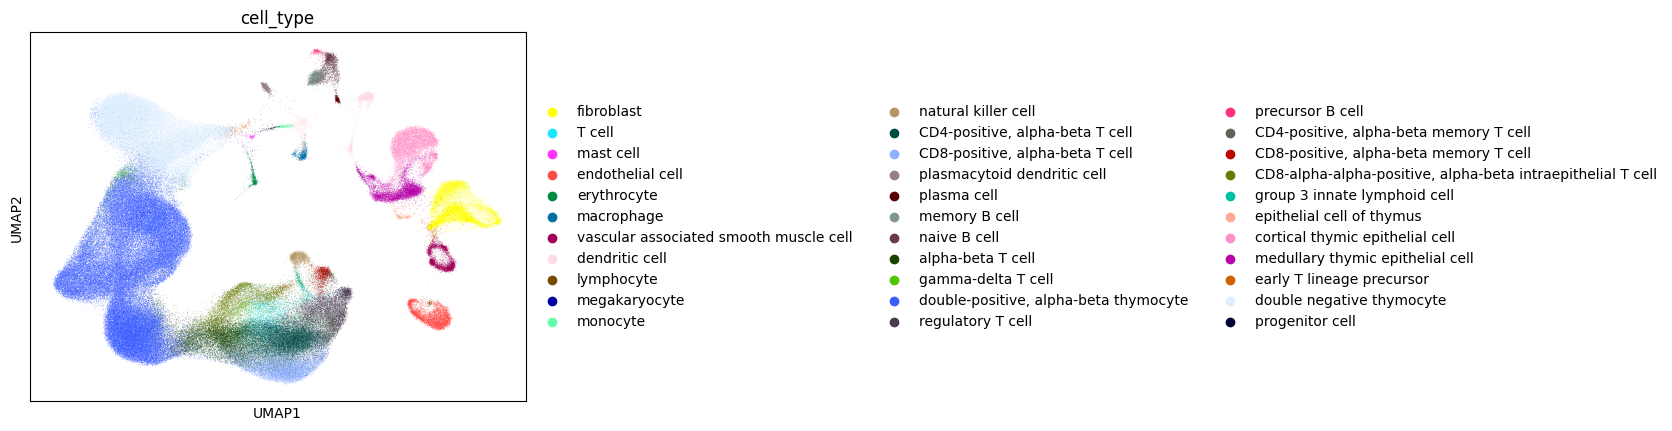

In [7]:
#| label: fig-umap
#| fig-cap: "UMAP in original dataset by cell type"

sc.pl.umap(dataset_anndata, color="cell_type")

In [1]:
#| label: check-up_list-gene
#| fig-cap: "Check if every ligne dans les folds sont bons"

# Read two file, to check the values in every fold for every cell type.
dataframe_liste_number_per_fold = pd.read_csv(os.path.join(PATH_EXPERIMENT_OUTPUT_ANALYSIS_RUN, "dataframe_liste_number_per_fold.csv"))
id_cell_type = pd.read_csv(os.path.join(PATH_EXPERIMENT_OUTPUT_ANALYSIS_RUN, "id_map_results_annotation.csv"))

# Duplicate columns ("0") to be able to do a merge with the same column ("Valeur").
id_cell_type["Valeur"] = id_cell_type["0"]
del id_cell_type["0"]
# Duplicate column
dataframe_liste_number_per_fold["Valeur"] = dataframe_liste_number_per_fold.index
# Merge the two dataframe
dataframe_liste_number_per_fold = pd.merge(dataframe_liste_number_per_fold, id_cell_type, on="Valeur")
dataframe_liste_number_per_fold.index = dataframe_liste_number_per_fold["fibroblast"]
# Clean the column useless
del dataframe_liste_number_per_fold["Valeur"]
del dataframe_liste_number_per_fold["fibroblast"]

dataframe_liste_number_per_fold

NameError: name 'pd' is not defined

### Indicator data analysis.

In [9]:
# Reading the indicator file
indicator_result_run = pd.read_csv(os.path.join(PATH_EXPERIMENT_OUTPUT_ANALYSIS_RUN, "indicators_results_annotation.csv"))

##### Plot fold

In [10]:
# Change the name inside the fold, for better comprehension
for i in range (0, len(indicator_result_run)):
    indicator_result_run.loc[i, "k_fold"] = 'Bloc ' + str(i)

/tmp/ipykernel_95/2512292935.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Bloc 0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  indicator_result_run.loc[i, "k_fold"] = 'Bloc ' + str(i)


In [11]:
# Change the name of indicator for best comprehension and display
indicator_result_run =indicator_result_run.rename(columns = {'mutual_info':"MI"})
indicator_result_run=indicator_result_run.rename(columns = {'rand_index':"RI"})
indicator_result_run=indicator_result_run.rename(columns = {'macro_f1':"Macro F1"})
indicator_result_run=indicator_result_run.rename(columns = {'accuracy':"Accuracy"})
indicator_result_run=indicator_result_run.rename(columns = {'precision':"Precision"})
indicator_result_run=indicator_result_run.rename(columns = {'recall':"Recall"})

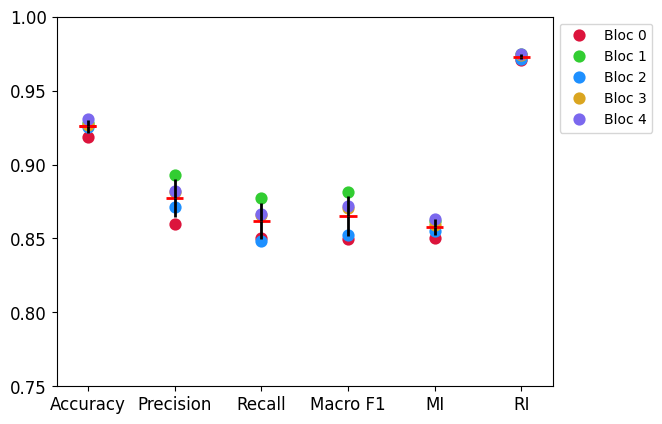

In [12]:
#| label: fig-pointplotindicator
#| fig-cap: "Point plot of values of the various indicators for all Folds supplied."

# Choice of colors for all folds (there must be as many colors as there are folds)
pattern_palette = {'Bloc 0': 'crimson', 'Bloc 1': 'limegreen', 'Bloc 2': 'dodgerblue', 'Bloc 3': 'goldenrod', 'Bloc 4':'mediumslateblue'}
# Create a new dataset to put the indicators, their folds and their values in columns for display in the graph.
df_indicator_result = indicator_result_run.melt(id_vars=['k_fold'], var_name='Indicator', value_name='Values')
# Point Plot of indicators and values, as a function of k_folds with mean and standard deviation.
ax = sns.pointplot(data=df_indicator_result, x='Indicator', y='Values', linestyle='none', hue='k_fold', palette=pattern_palette)

# Add averages for each indicator
xmin=-0.1
xmax=0.1
plt.hlines(xmin=-0.1, xmax=0.1 ,y = indicator_result_run["Accuracy"].mean(), colors='red', lw=2)
for i in indicator_result_run:
    if i != "k_fold":
        plt.hlines(xmin=xmin, xmax=xmax ,y = indicator_result_run[i].mean(), colors='red', lw=2)
        xmax = xmax + 1
        xmin = xmin + 1
# Add variance for each indicator
acc_coord_x = 0
for i in indicator_result_run:
    if i != "k_fold":
        Ecart_type_bas = indicator_result_run[i].mean() - stdev(indicator_result_run[i])
        Ecart_type_haut = stdev(indicator_result_run[i]) + indicator_result_run[i].mean()
        plt.vlines(x = acc_coord_x, ymin= indicator_result_run[i].mean(), ymax = Ecart_type_haut, colors='black', lw=2)
        plt.vlines(x = acc_coord_x, ymin= indicator_result_run[i].mean(), ymax = Ecart_type_bas, colors='black', lw=2)
        acc_coord_x = acc_coord_x + 1

# Change the parameter for the plot.
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.ylim(0.75, 1)
ax.set_xlabel("", fontsize=1) #Remove the name that don't interest us
ax.set_ylabel("", fontsize=1) #Remove the name that don't interest us
plt.xticks(fontsize=12) #change the size of label x
plt.yticks(fontsize=12) #change the size of label y

#plt.savefig('/mnt/DOSI/PLATEFORMES/BIOINFORMATIQUE/04_PROJECT/scLLM/Human_Thymus_Development_Atlas/05_Output/fig/Human_Thymus_all_fold_run_epoch_10_scGPT.png', bbox_inches='tight')
plt.show()

##### Data

In [13]:
#| label: fig-tableindicator
#| fig-cap: "Indicator data table."

indicator_result_run

Accuracy  Precision    Recall  Macro F1        MI        RI  k_fold
0  0.918783   0.859672  0.850419  0.849323  0.850383  0.970411  Bloc 0
1  0.928037   0.893098  0.877281  0.881256  0.861782  0.974527  Bloc 1
2  0.925277   0.871121  0.848225  0.852211  0.854697  0.971418  Bloc 2
3  0.927064   0.881212  0.865766  0.870560  0.859237  0.973961  Bloc 3
4  0.930627   0.881819  0.866455  0.871680  0.863170  0.974988  Bloc 4

## Data analysis of Folds set prediction values.

In [14]:
#| label: fig-tablematrix
#| fig-cap: "Table of all the values of the diagonals of the confusion matrices for the different Folds, with mean and variance."

# Creation of a list containing all the files and directories in the run.
liste_directorie_run = os.listdir(PATH_EXPERIMENT_OUTPUT_ANALYSIS_RUN)
# We sort the list so that the numbers are in the right order.
liste_directorie_run = np.sort(liste_directorie_run)
# Creating an empty dataframe
df_diagonal_value_matrix = pd.DataFrame()
# Browse the list
for elt in liste_directorie_run:
    # Stores string elements in string format
    chaine=str(elt)
    # If the item has "K_Fold" then we'll enter the directory.
    if "K_Fold" in chaine :
        # We create a path containing the directory to be able to access it
        PATH_K_FOLD = os.path.join( PATH_EXPERIMENT_OUTPUT_ANALYSIS_RUN, chaine)
        # We read the confusion matrix in the above directory.
        matrix_confusion = pd.read_csv(os.path.join(PATH_K_FOLD, "matrix_confusion_results_annotation.csv"))
        # We index the cell types
        matrix_confusion.index = matrix_confusion["Unnamed: 0"]
        # The cell type column in the index is now deleted.
        del matrix_confusion["Unnamed: 0"]
        # The index is stored in our dataframe in a column named “CellType”.
        df_diagonal_value_matrix["CellType"] = matrix_confusion.index
        # We store the set of values present in the diagonal of the matrix in the column named K_Fold_ and its name
        df_diagonal_value_matrix[chaine] = np.diag(matrix_confusion)
        
# We replace the matrix index with the cell type names
df_diagonal_value_matrix.index = df_diagonal_value_matrix['CellType']
# We remove the cell type column, which is now in the index, to have only numerical values.
del df_diagonal_value_matrix['CellType']
# Because we delete the Cell TYpe we are now able to, add column with mean and variance values without error
df_diagonal_value_matrix['Variance'] = df_diagonal_value_matrix.var(axis='columns')
df_diagonal_value_matrix['Mean'] = df_diagonal_value_matrix.loc[:,[c for c in df_diagonal_value_matrix.columns if c!= "Variance"]].mean(axis=1)

##### Plot

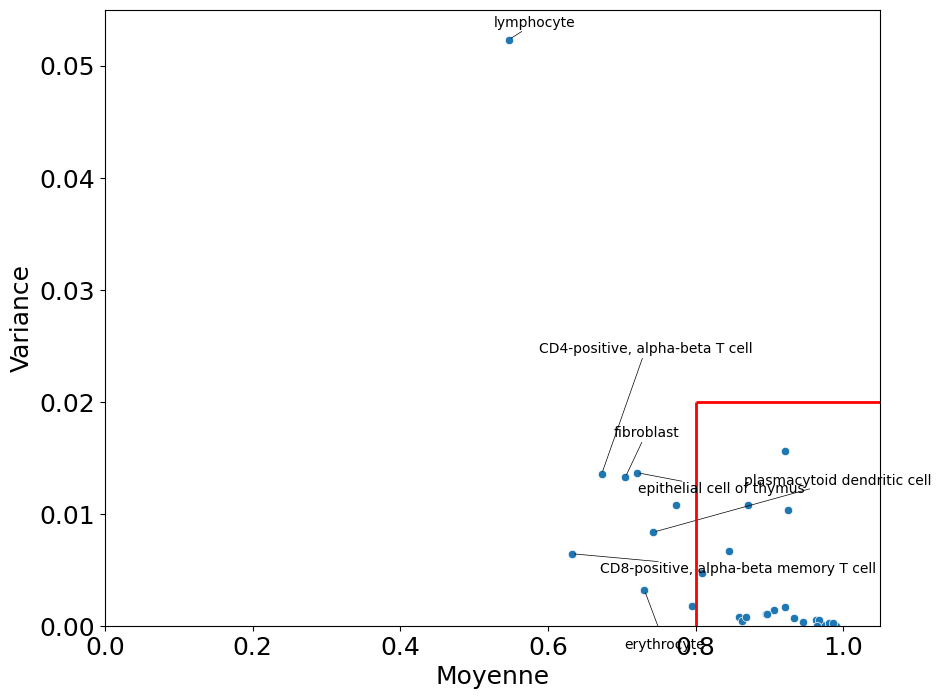

In [15]:
#| label: fig-scattermatrixcelltypeepoch_1
#| fig-cap: "Scatter plot of variance versus mean, each point represents the cell type name"

# We need back "Cell_Type" in a column different that index.
df_diagonal_value_matrix['Cell_Type'] = df_diagonal_value_matrix.index

# Modifie the size of the plot
fig, ax = plt.subplots(figsize = (10,8))
# We create the graph with the value
sns.scatterplot(data=df_diagonal_value_matrix, x="Mean", y="Variance") # Alternative sns.scatterplot(data=df_diagonal_value_matrix, x="Mean", y="Variance")

# Put the line inside the graph for the best and the worst prediction
plt.hlines(xmin=BEST_MEAN_PREDICTION, xmax=1.05 ,y = BEST_VARIANCE_PREDICTION, colors='red', lw=2)
plt.vlines(x=BEST_MEAN_PREDICTION, ymin = 0, ymax=BEST_VARIANCE_PREDICTION, colors='red', lw=2)

# For loop to put the name of cell type above the dot.
texts = []
for idx, row in df_diagonal_value_matrix.iterrows():
    # Select the cell type who gonna have their name on top of them
    if row['Mean'] < 0.75 or row['Variance'] > 0.05:
        # Annotate
        texts.append(plt.text(row['Mean'], row['Variance'], row['Cell_Type']))

adjust_text(texts, expand=(1.2, 5), # expand text bounding boxes by 1.2 fold in x direction and 2 fold in y direction
            arrowprops=dict(arrowstyle="-", color='k', lw=0.5, )) # ensure the labeling is clear by adding arrows)

# Change the parameter for the plot.
plt.ylim(0,0.055)
plt.xlim(0,1.05)
ax.set_xlabel("Moyenne", fontsize=18)
ax.set_ylabel("Variance", fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

#plt.savefig('/mnt/DOSI/PLATEFORMES/BIOINFORMATIQUE/04_PROJECT/scLLM/Human_Thymus_Development_Atlas/05_Output/fig/Human_Thymus_Mean_Var_run_epoch_10_scGPT.png', bbox_inches='tight')
plt.show()

##### Data

##### Best prediction Cell-Type

In [42]:
#| label: fig-scattermatrixcelltype_best
#| fig-cap: "Dataframe of the best predictions obtained."

df_diagonal_best_prediction = df_diagonal_value_matrix.loc[(df_diagonal_value_matrix['Mean'] >= BEST_MEAN_PREDICTION) & (df_diagonal_value_matrix['Variance'] <= BEST_VARIANCE_PREDICTION)]
df_diagonal_best_prediction

K_Fold_0  K_Fold_1  \
CellType                                                                 
CD8-positive, alpha-beta T cell                     0.993617  0.992340   
CD8-alpha-alpha-positive, alpha-beta intraepith...  0.986968  0.968723   
regulatory T cell                                   0.984496  0.968992   
alpha-beta T cell                                   0.942197  0.982659   
T cell                                              0.969657  0.977573   
double negative thymocyte                           0.937143  0.874286   
dendritic cell                                      0.910941  0.926209   
CD4-positive, alpha-beta memory T cell              0.853549  0.767322   
natural killer cell                                 1.000000  0.966667   
macrophage                                          0.895833  0.968750   
memory B cell                                       0.951501  0.974537   
early T lineage precursor                           0.954211  0.979575   
precursor B cell                                    0.720721  0.918919   
endothelial cell                                    0.963356  0.996812   
cortical thymic epithelial cell                     0.987491  0.922168   
plasma cell                                         0.977163  0.958093   

                                                    K_Fold_2  K_Fold_3  \
CellType                                                                 
CD8-positive, alpha-beta T cell                     0.987660  0.994468   
CD8-alpha-alpha-positive, alpha-beta intraepith...  0.987837  0.997391   
regulatory T cell                                   0.968992  0.992248   
alpha-beta T cell                                   0.976879  0.767442   
T cell                                              0.982850  0.956407   
double negative thymocyte                           0.893333  0.965714   
dendritic cell                                      0.882952  0.860051   
CD4-positive, alpha-beta memory T cell              0.871424  0.866598   
natural killer cell                                 0.976190  0.976077   
macrophage                                          0.968750  0.979167   
memory B cell                                       0.900463  0.976852   
early T lineage precursor                           0.977774  0.974841   
precursor B cell                                    0.963964  0.801802   
endothelial cell                                    0.986185  0.978215   
cortical thymic epithelial cell                     0.922863  0.965229   
plasma cell                                         0.961271  0.931254   

                                                    K_Fold_4  Variance  \
CellType                                                                 
CD8-positive, alpha-beta T cell                     0.992337  0.000007   
CD8-alpha-alpha-positive, alpha-beta intraepith...  0.992174  0.000117   
regulatory T cell                                   0.976562  0.000102   
alpha-beta T cell                                   0.959302  0.008078   
T cell                                              0.963012  0.000114   
double negative thymocyte                           0.961905  0.001683   
dendritic cell                                      0.933673  0.000947   
CD4-positive, alpha-beta memory T cell              0.847983  0.001804   
natural killer cell                                 0.990431  0.000175   
macrophage                                          0.978947  0.001246   
memory B cell                                       0.812500  0.004772   
early T lineage precursor                           0.970467  0.000104   
precursor B cell                                    0.800000  0.009719   
endothelial cell                                    0.998406  0.000209   
cortical thymic epithelial cell                     0.898470  0.001306   
plasma cell                                         0.952319  0.000276   

                                                     

##### Worst prediction Cell-Type

In [43]:
#| label: fig-scattermatrixcelltype_worst
#| fig-cap: "Dataframe of worst-case predictions"

df_diagonal_worst_prediction = df_diagonal_value_matrix.loc[(df_diagonal_value_matrix['Mean'] <= WORST_MEAN_PREDICTION) & (df_diagonal_value_matrix['Variance'] >= WORST_VARIANCE_PREDICTION)]
df_diagonal_worst_prediction

K_Fold_0  K_Fold_1  K_Fold_2  K_Fold_3  K_Fold_4  Variance  \
CellType                                                                   
monocyte      0.000000  0.739130  0.652174  0.086957  0.000000  0.135539   
naive B cell  0.792453  0.679245  0.622642  0.792453  0.075472  0.088928   

                  Mean     Cell_Type  
CellType                              
monocyte      0.295652      monocyte  
naive B cell  0.592453  naive B cell

### Graph of all Folds confusion matrices

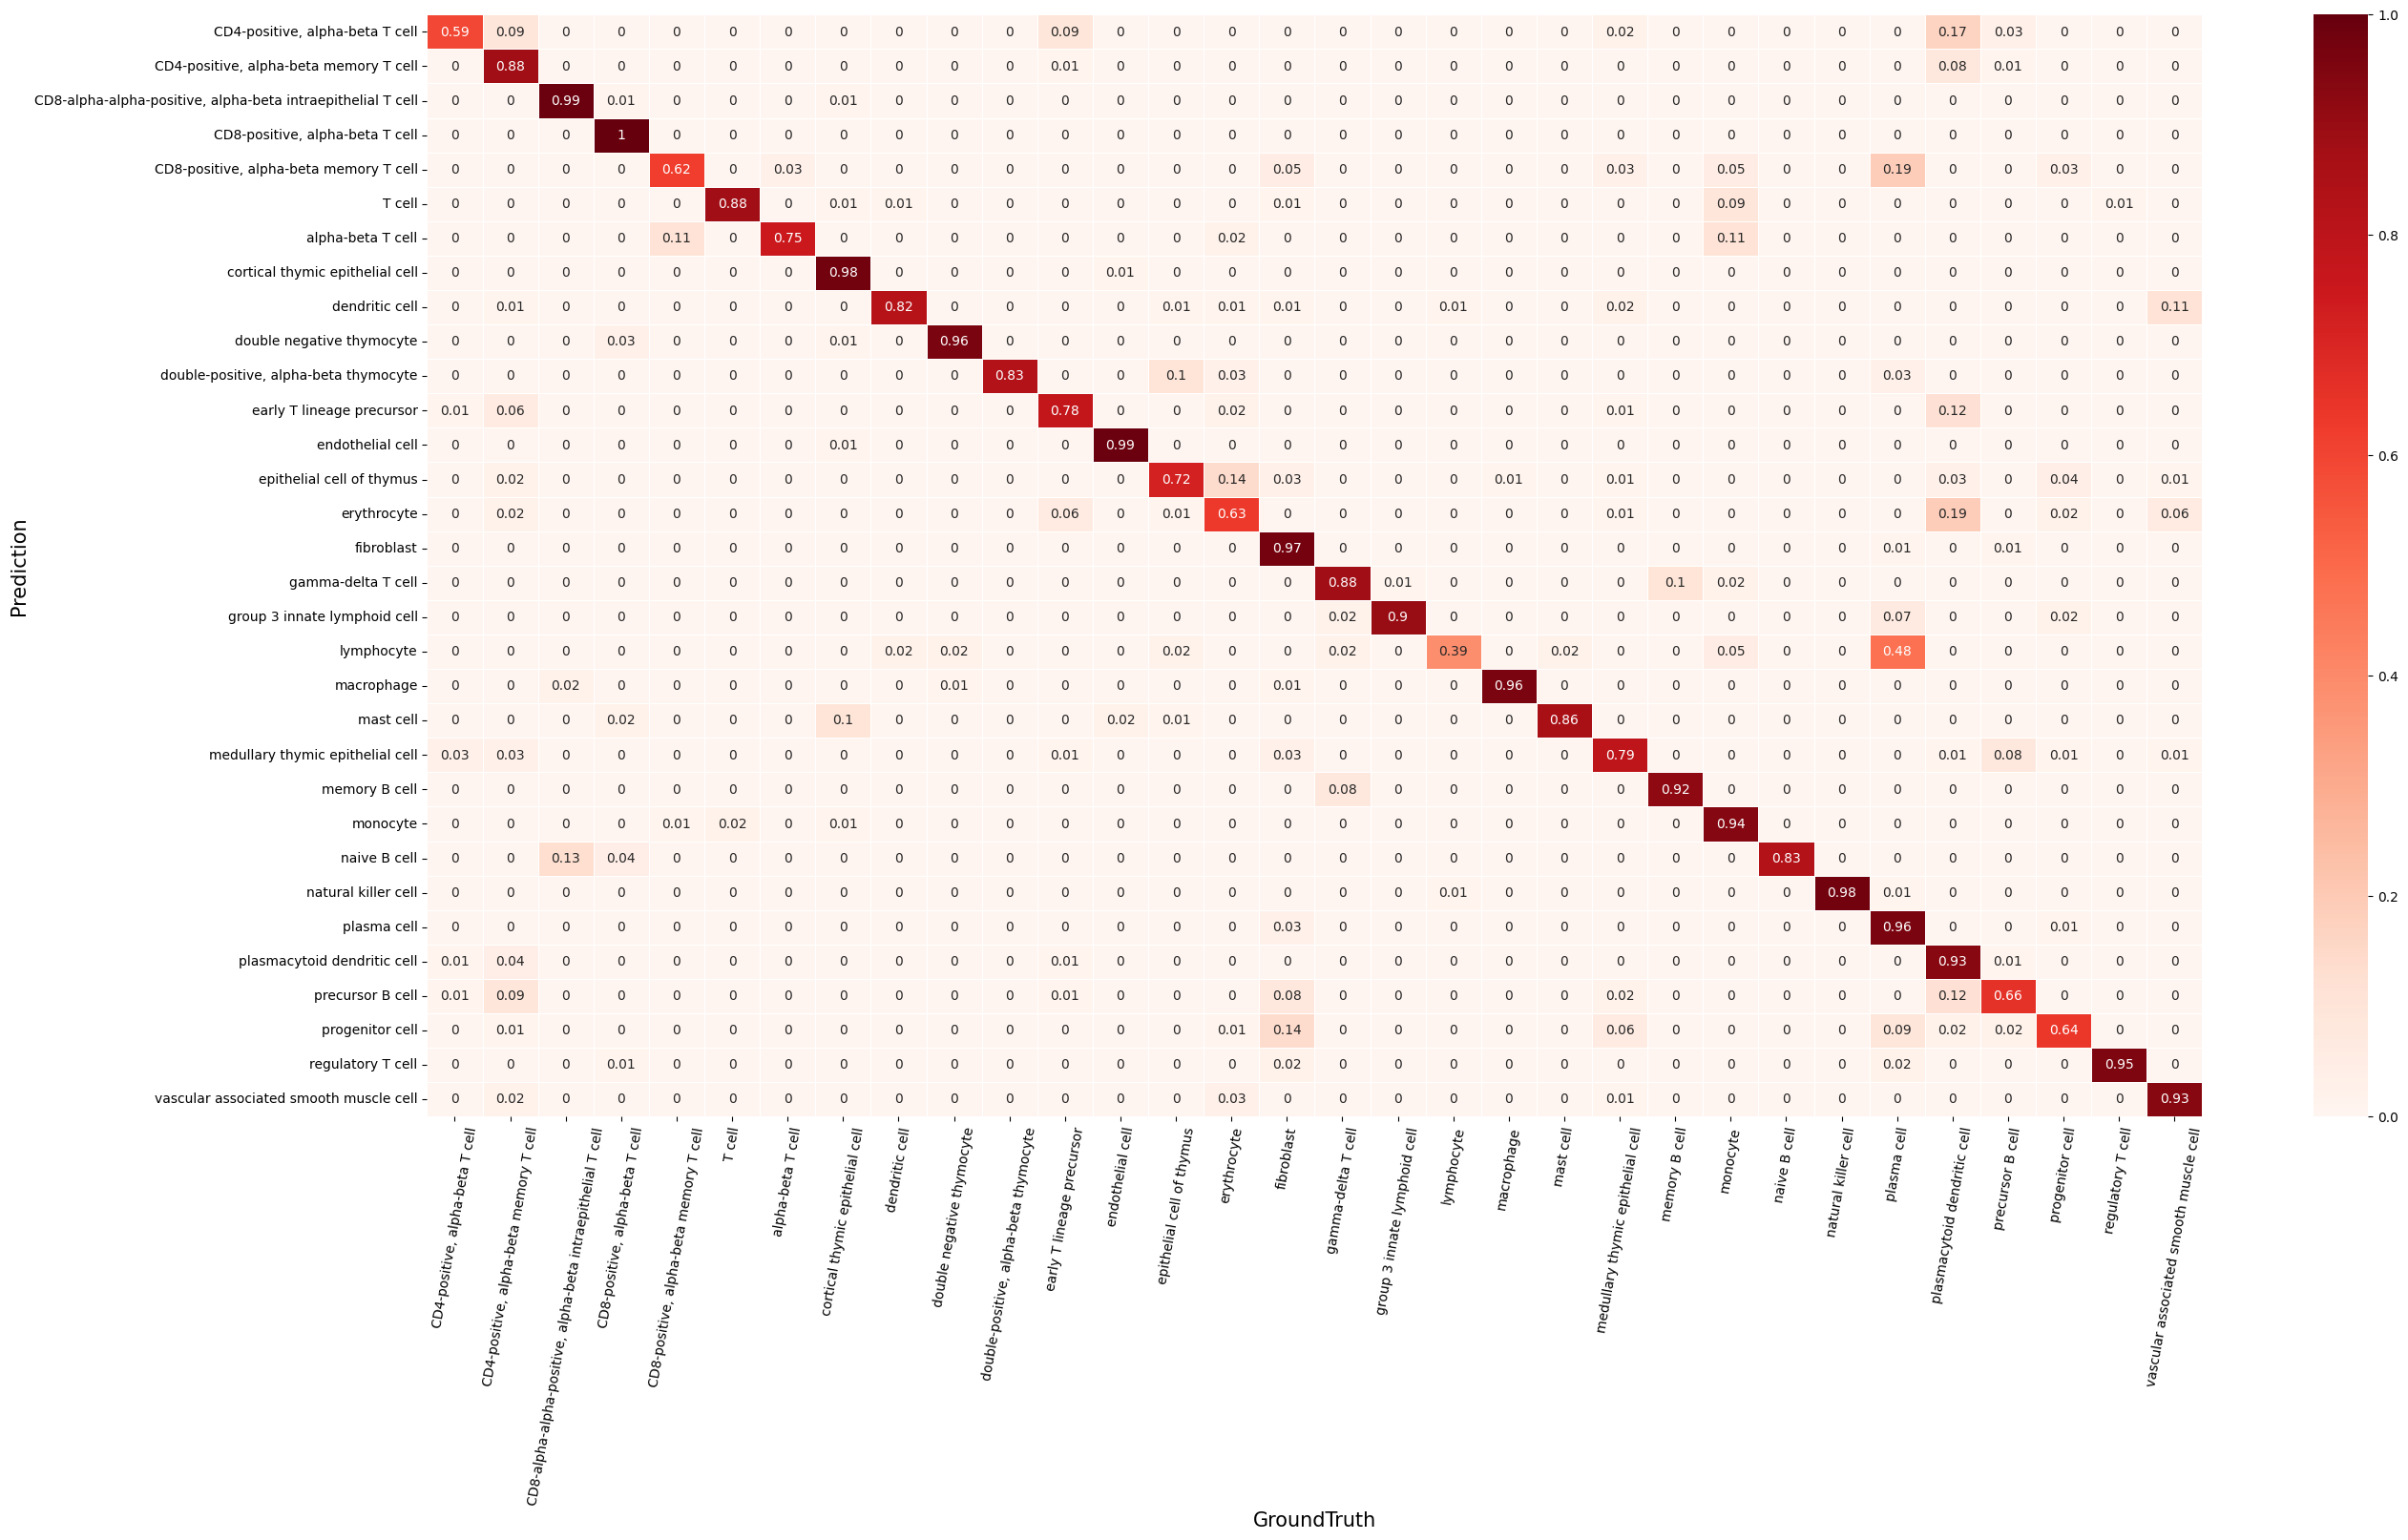

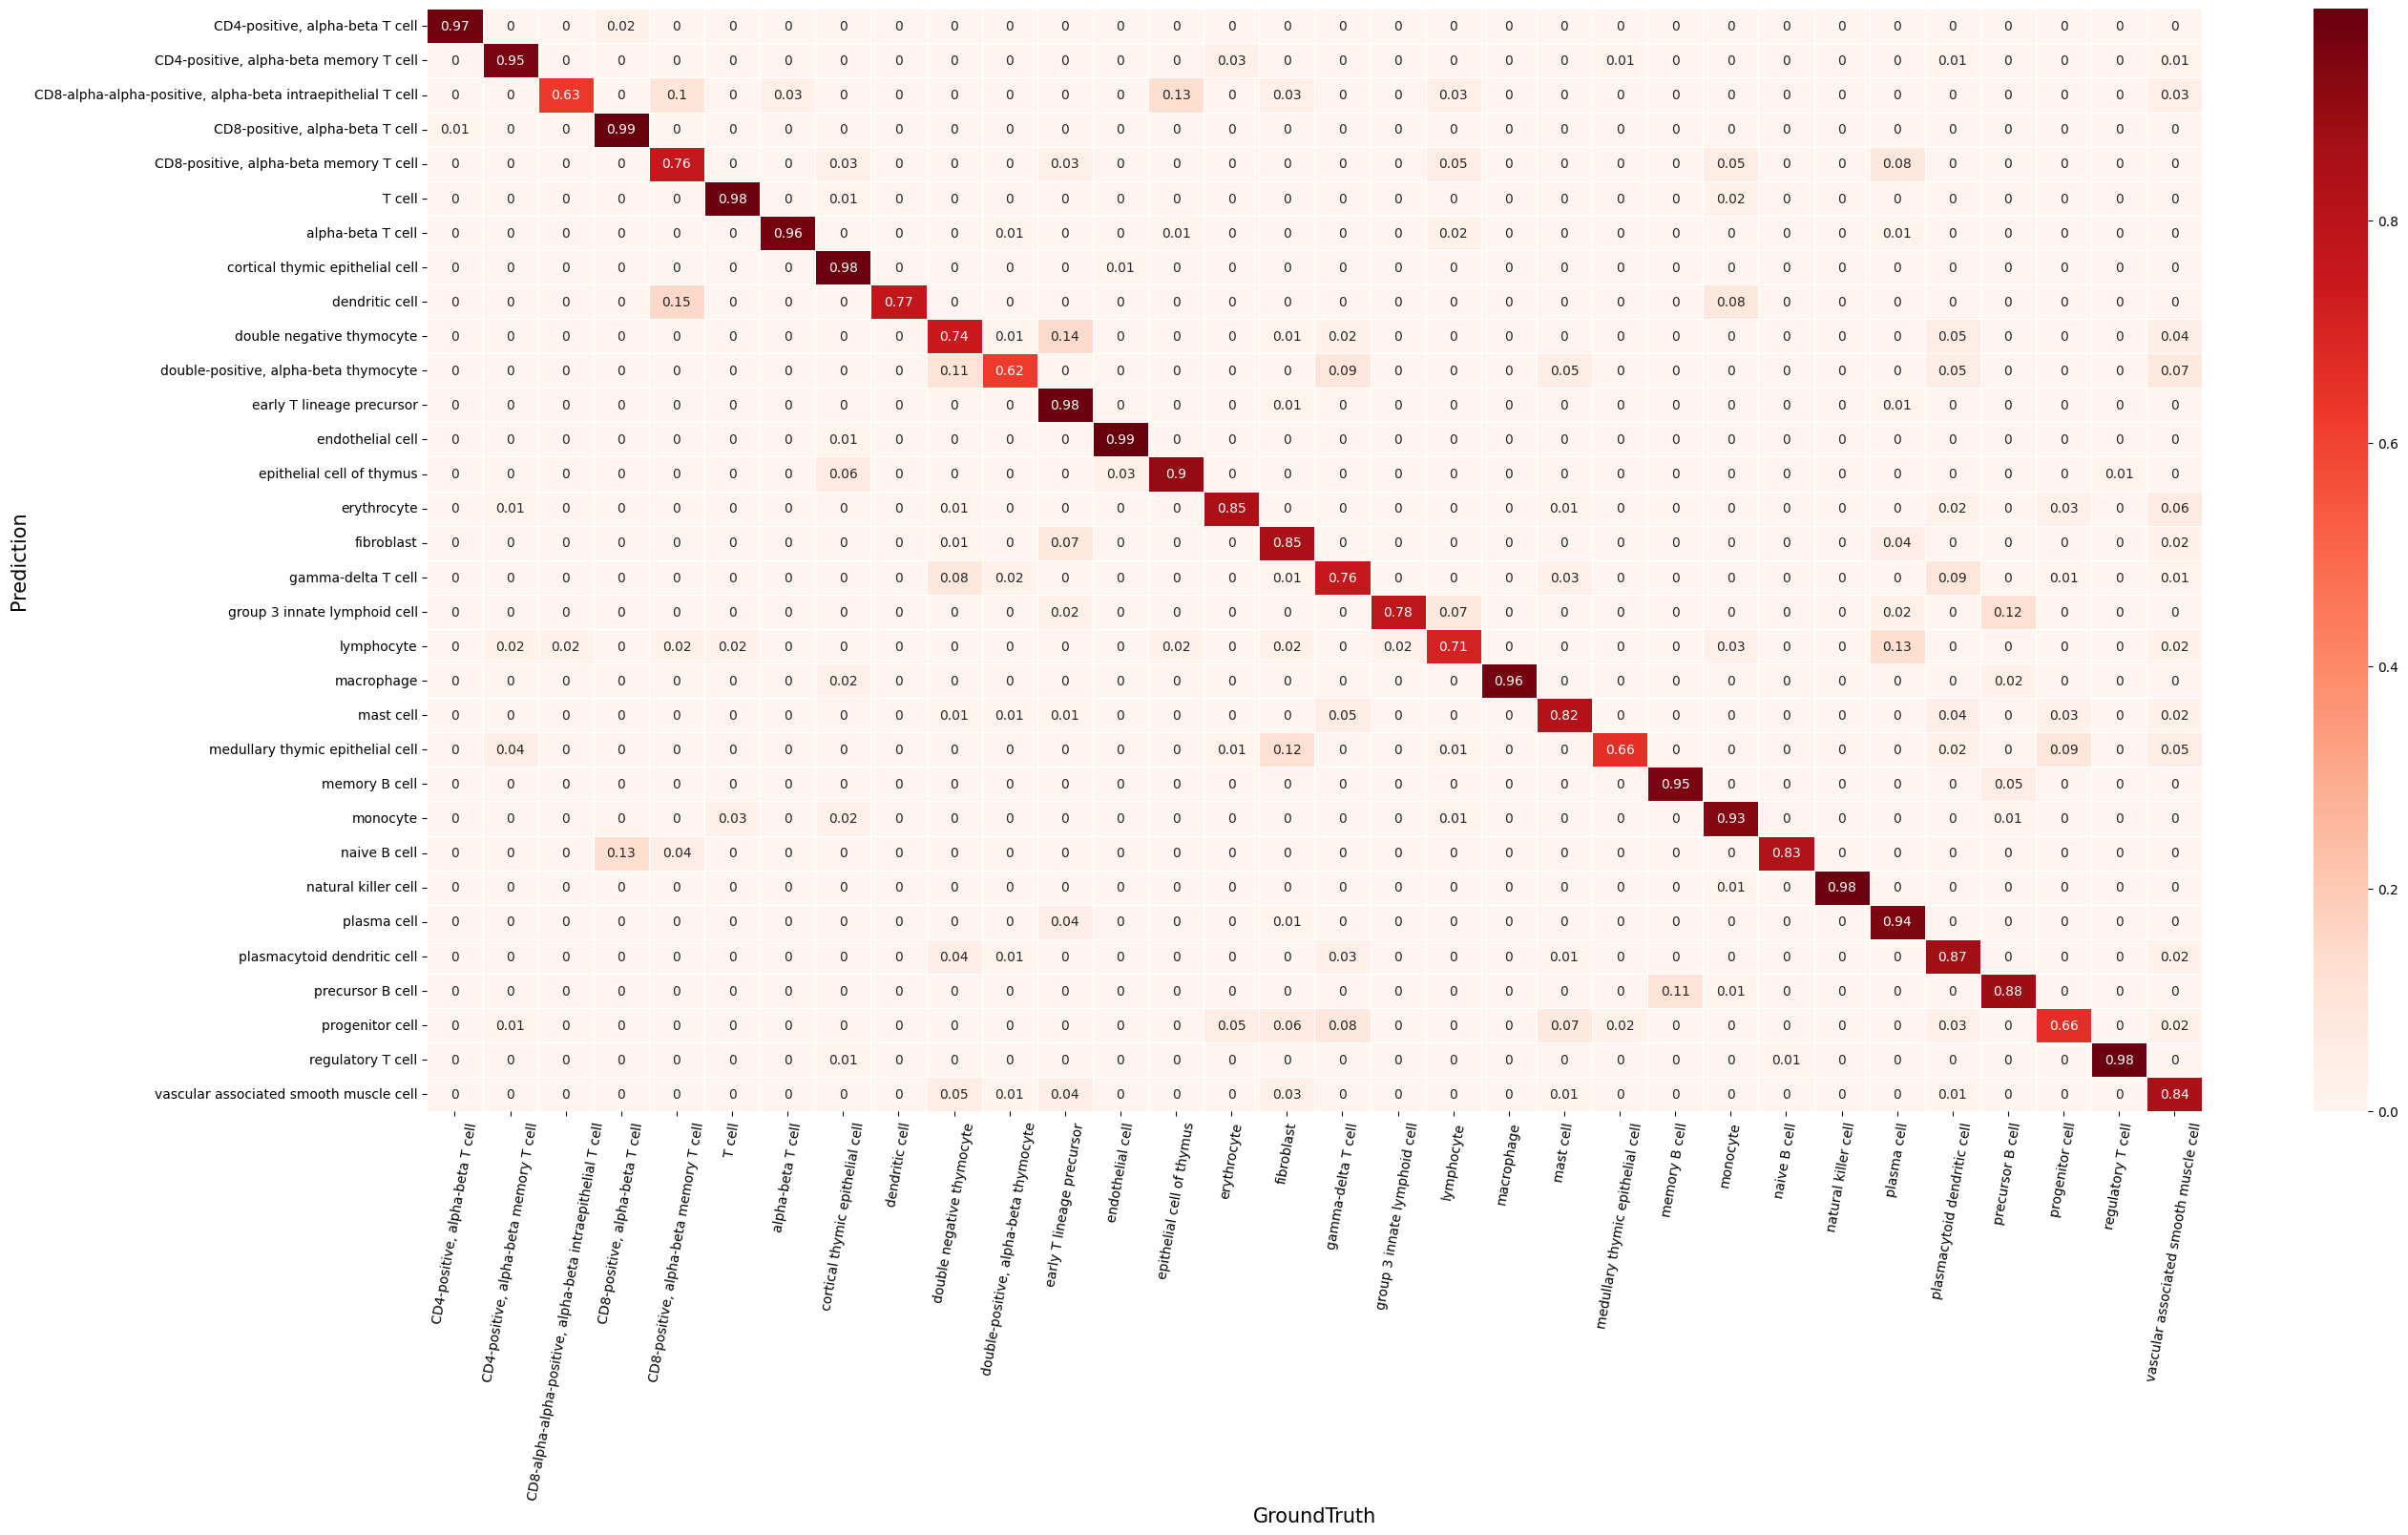

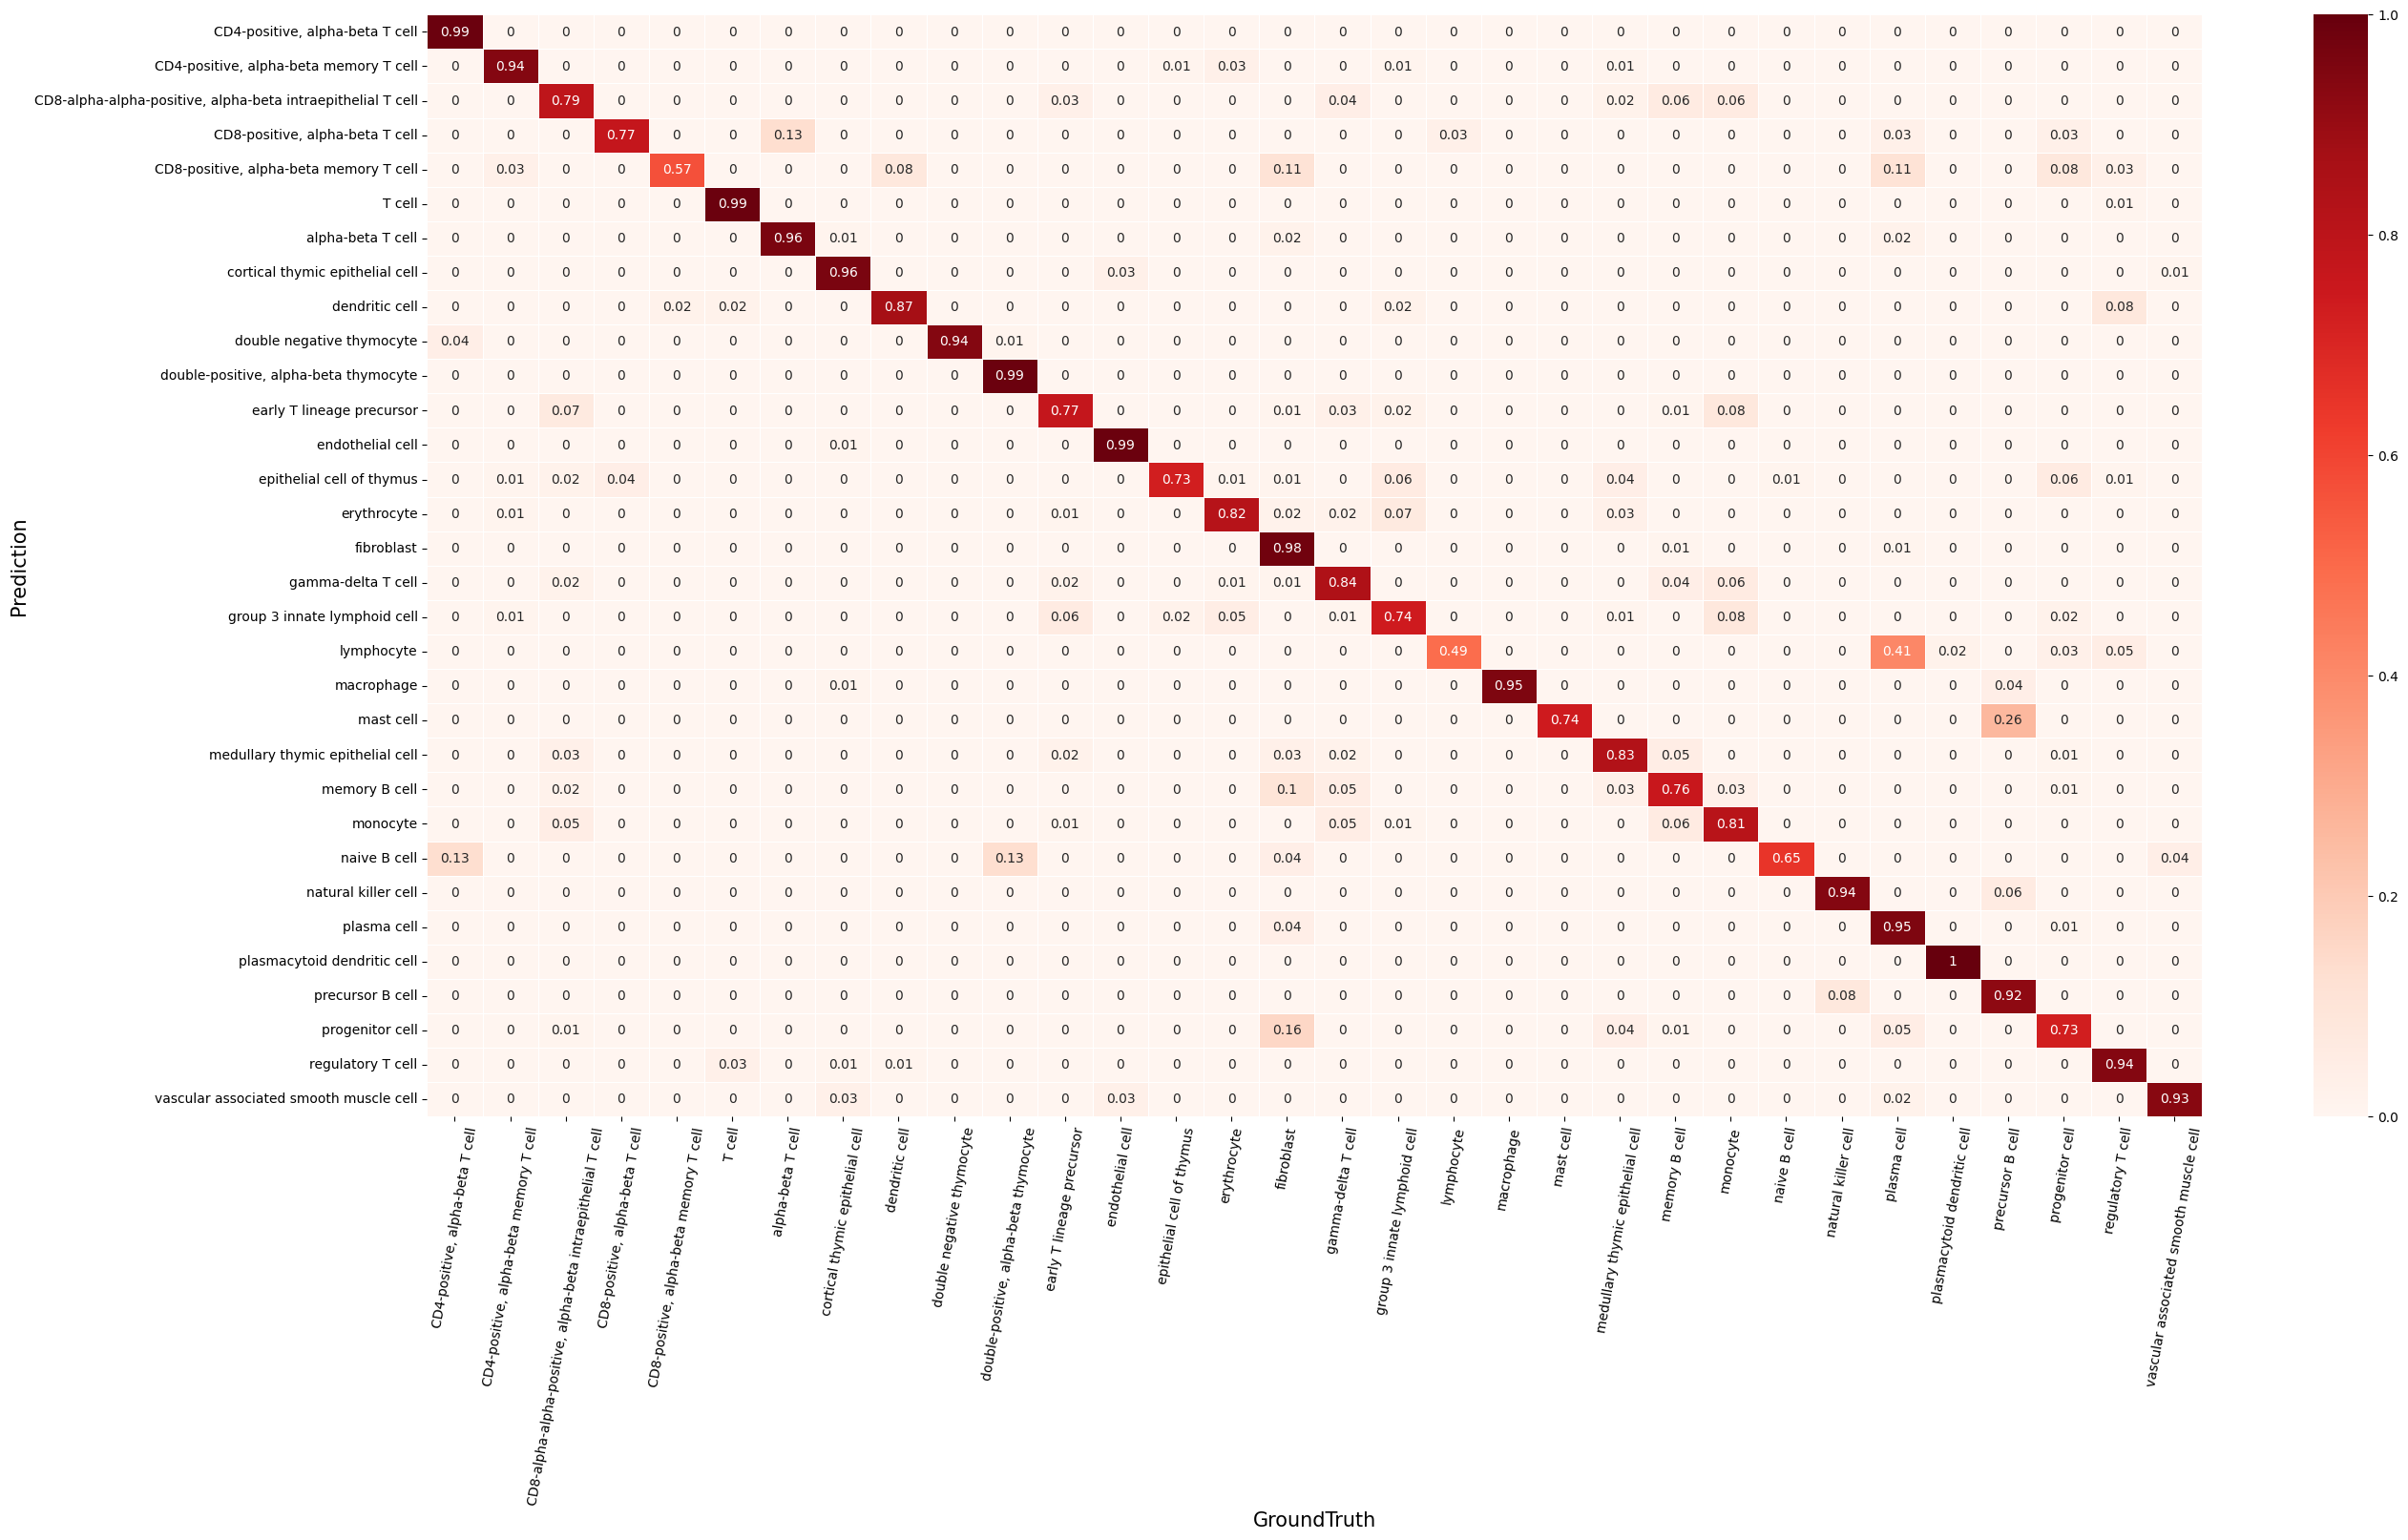

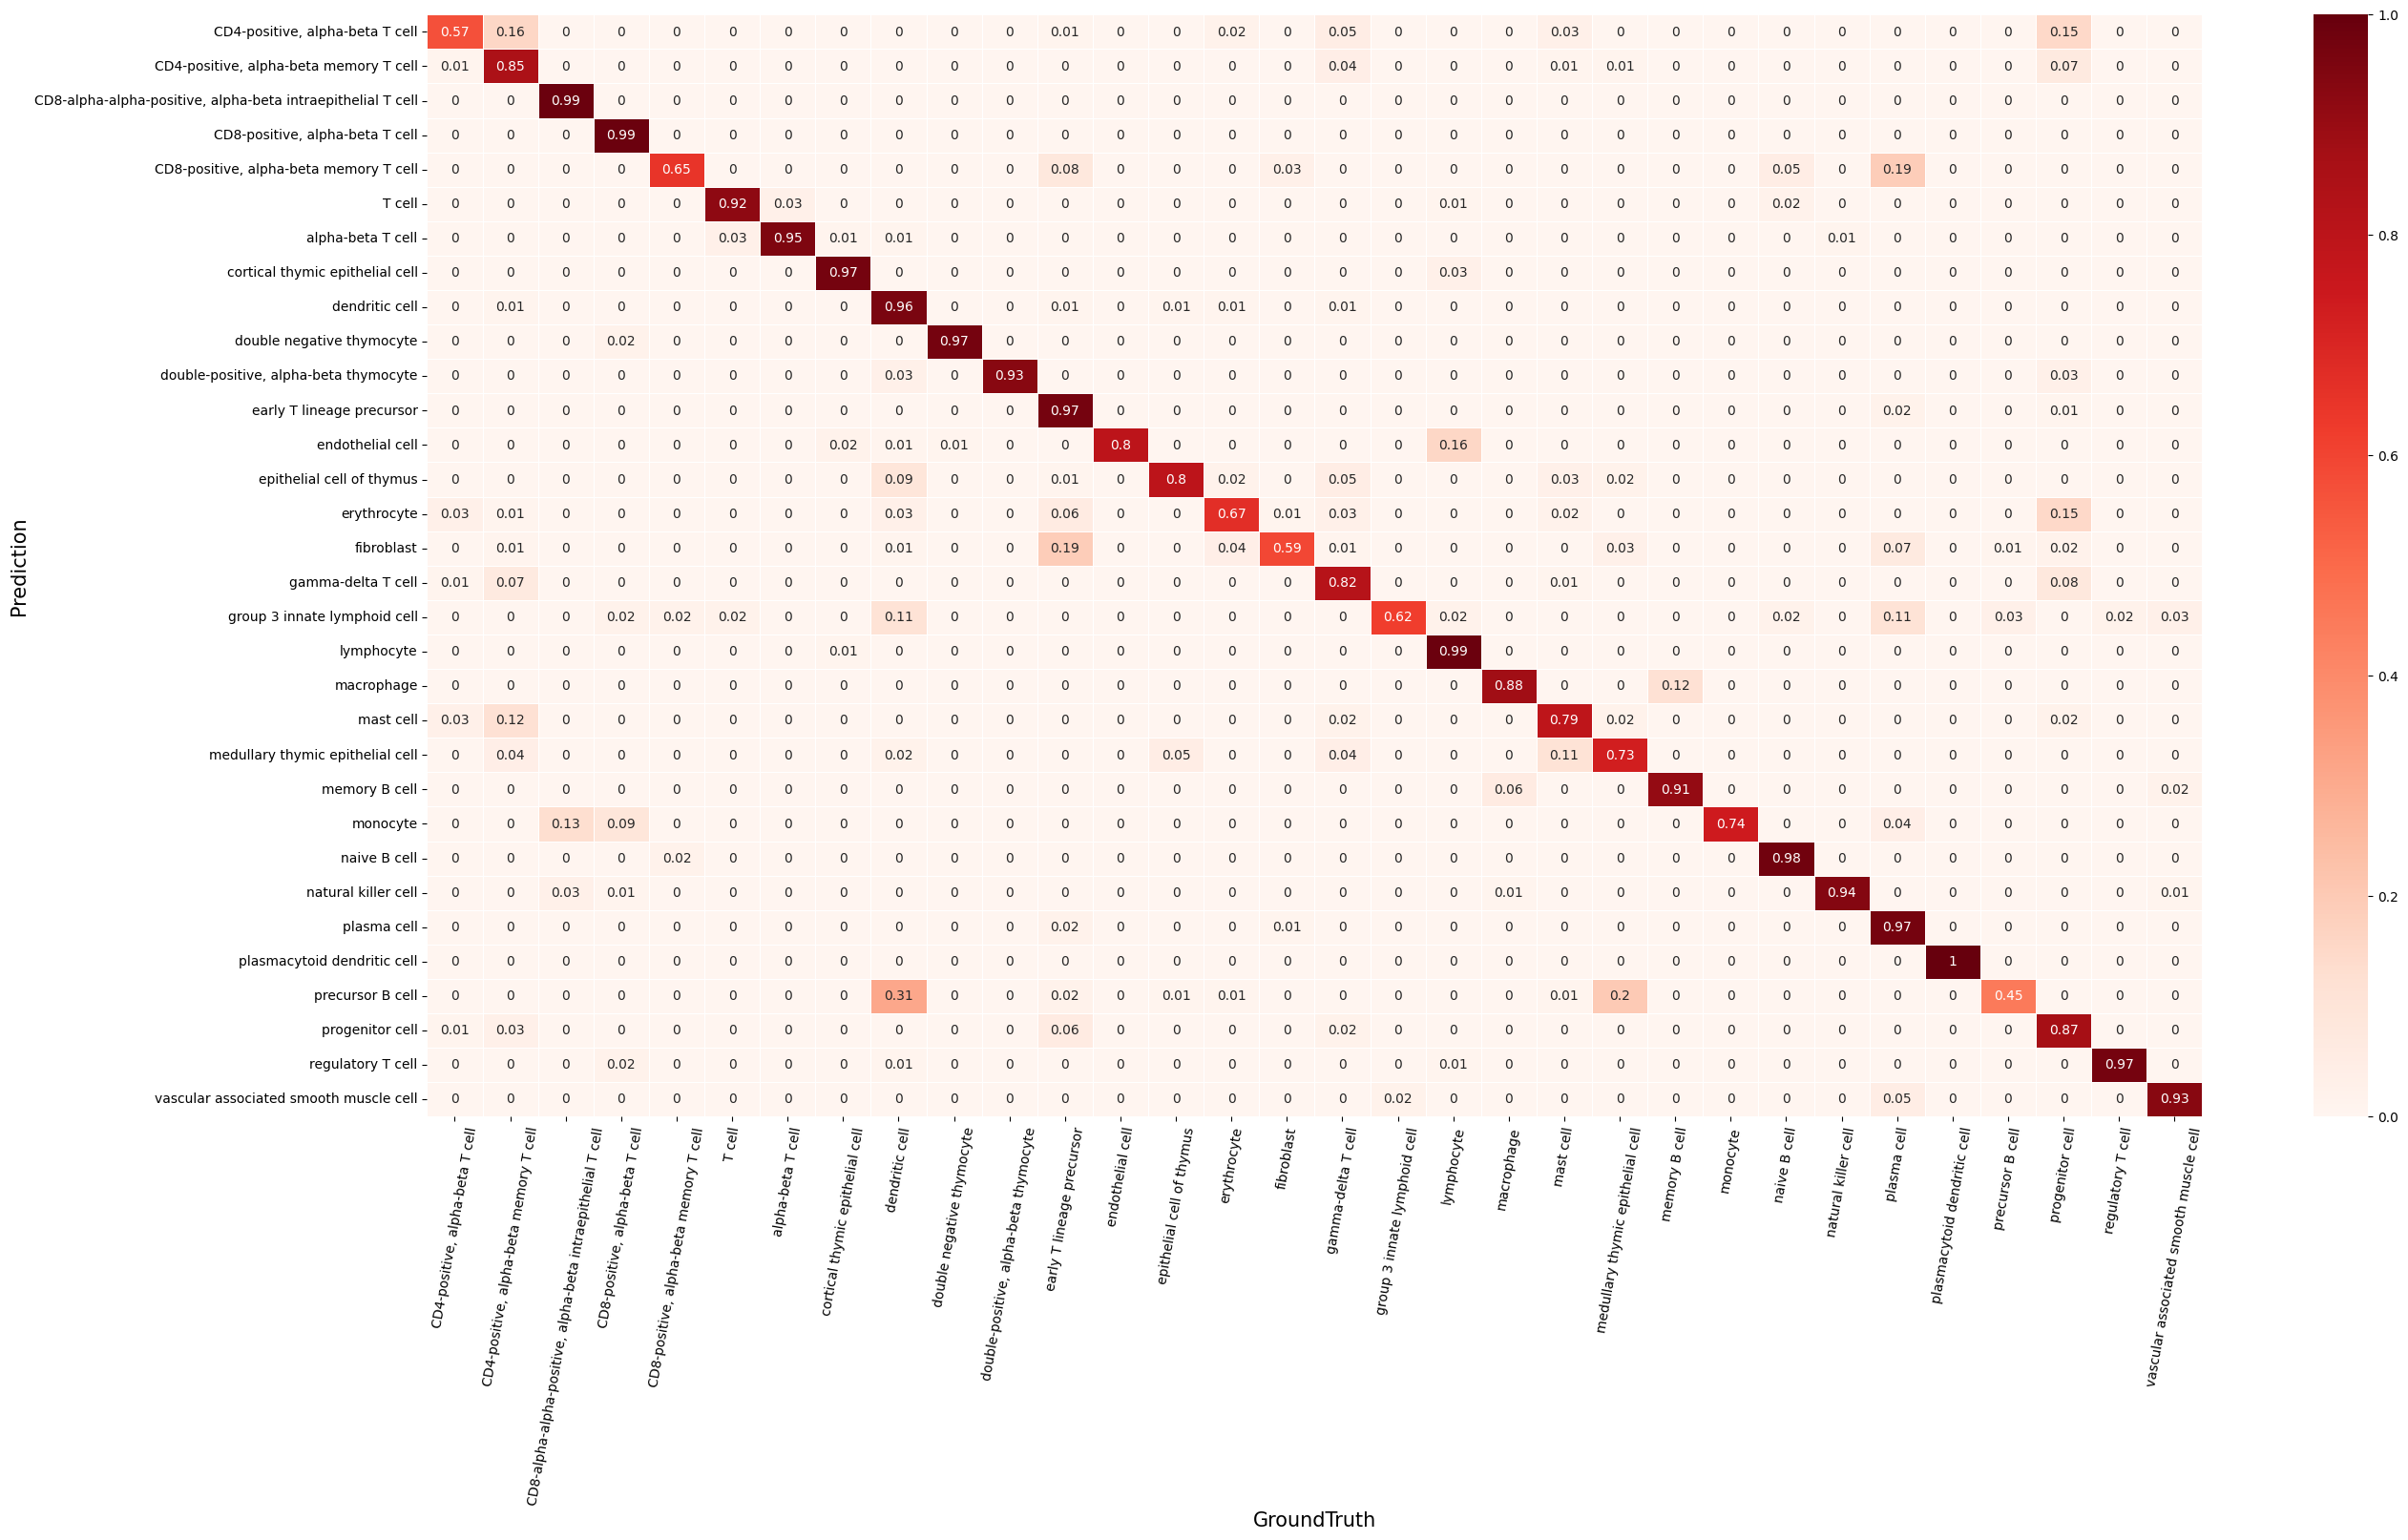

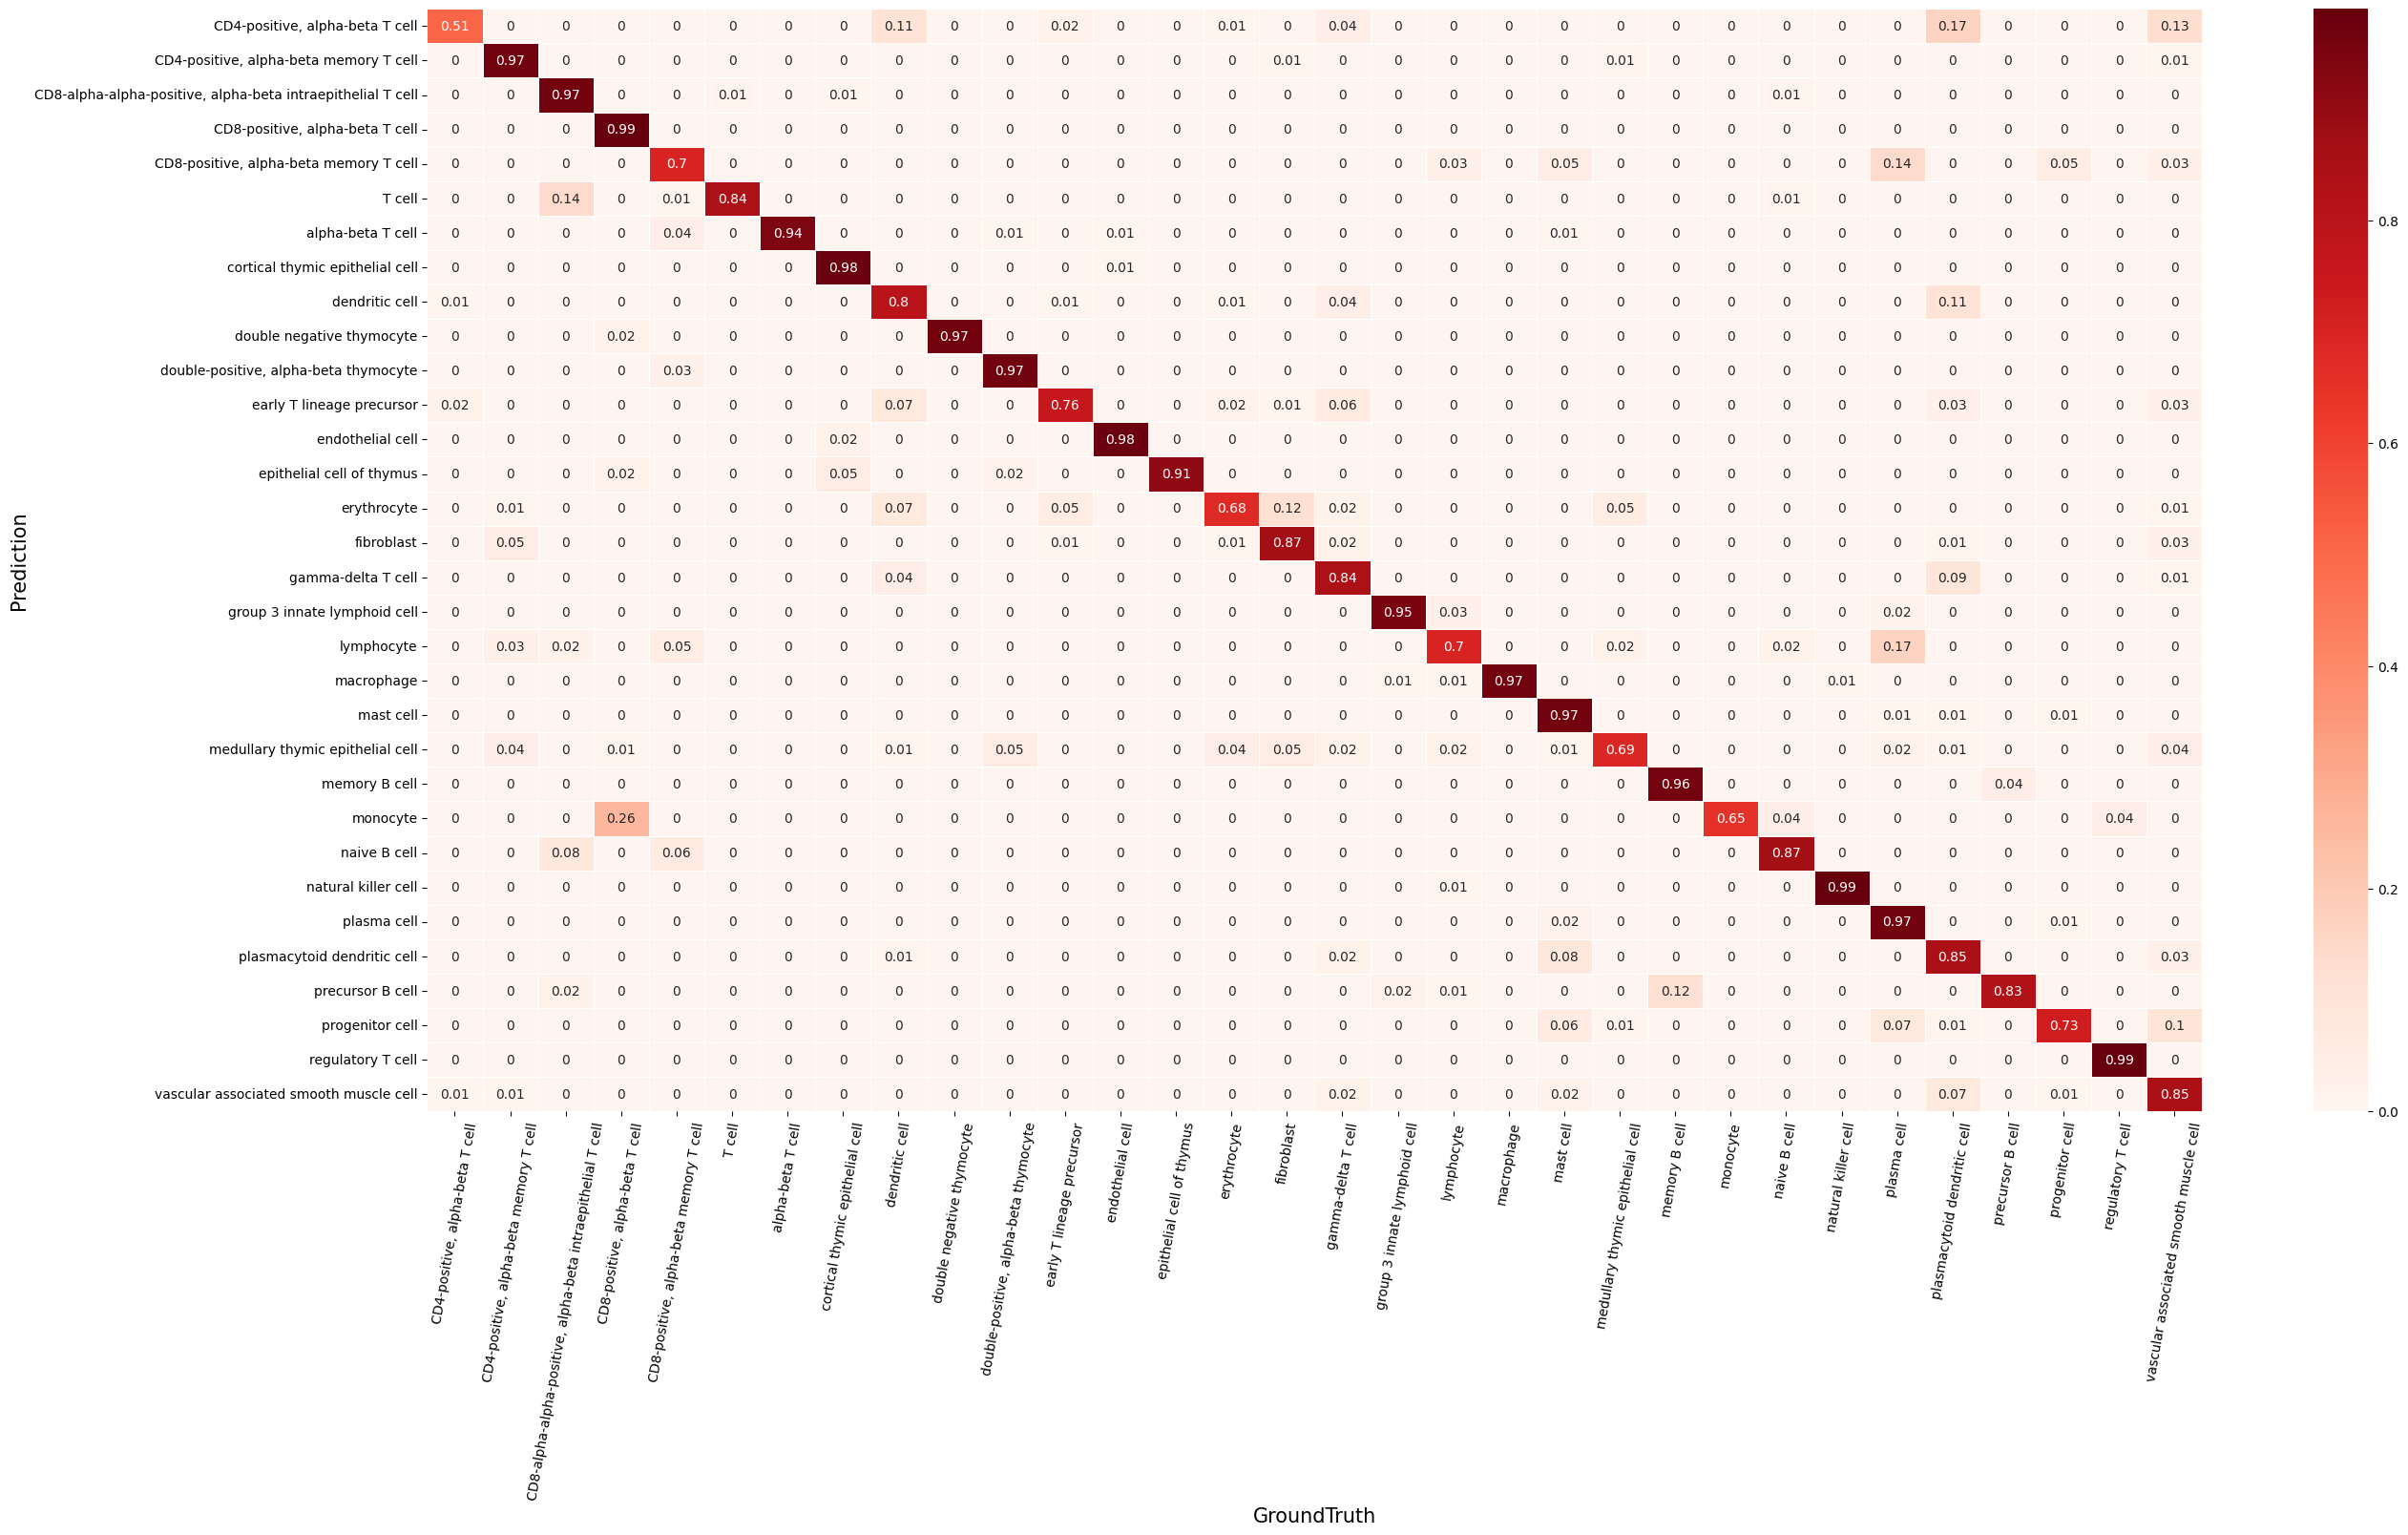

In [34]:
#| label: fig-scattermatrixfile
#| fig-cap: "Graph of all Folds confusion matrices"
#| fig-subcap: 
#|   - "Fold 0 confusion matrix"
#|   - "Fold 1 confusion matrix"
#|   - "Fold 2 confusion matrix"
#|   - "Fold 3 confusion matrix"
#|   - "Fold 4 confusion matrix"
#| layout-ncol: 5

# Creation of a list containing all files and directories in the run
liste_directorie_run = os.listdir(PATH_EXPERIMENT_OUTPUT_ANALYSIS_RUN)
# We sort the list so that the numbers are in the right order.
liste_directorie_run = np.sort(liste_directorie_run)

for elt in liste_directorie_run:
    # Stores string elements in string format
    chaine=str(elt)
    # If the element has “K_Fold” then we'll enter the directory
    if "K_Fold" in chaine :
        # Create a path containing the directory to access it run_03_epoch_5
        PATH_K_FOLD = os.path.join( PATH_EXPERIMENT_OUTPUT_ANALYSIS_RUN, chaine)
        # We read the confusion matrix in the above directory.
        matrix_confusion = pd.read_csv(os.path.join(PATH_K_FOLD, "matrix_confusion_results_annotation.csv"))
        # We index the cell types
        matrix_confusion.index = matrix_confusion["Unnamed: 0"]
        # The cell type column in the index is now deleted.
        del matrix_confusion["Unnamed: 0"]
        matrix_confusion = round(matrix_confusion, 2)
        matrix_confusion.index.names = ["Prediction"]
        # Retrieves cell type names to arrange them in order
        list_cell_type_name = matrix_confusion.index.values.tolist()
        # Arrange cell types in alphabetical order
        list_cell_type_name = np.sort(list_cell_type_name)
        # Sort the the confusion table, to make it identical for all matrices.
        matrix_confusion = matrix_confusion.reindex(index = list_cell_type_name, columns = list_cell_type_name)

        fig, ax = plt.subplots(figsize=(30,15))
        sns.heatmap(matrix_confusion, annot=True, linewidth=0.5, ax=ax, cmap="Reds")
        # ax.tick_params(axis = 'x', labelsize = 10) #Changes the size of cell type names
        ax.tick_params(axis = 'x', rotation = 80) #Change direction/rotation of cell type names
        plt.xlabel('GroundTruth', fontsize = 15)
        plt.ylabel('Prediction', fontsize = 15)
        plt.show()
